In [7]:
# 1) Imports and display configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set plotting style
sns.set(style="whitegrid", context="talk")

# 2) Load the dataset
file_path = "Dataset4_EWS.xlsx"  # adjust path if needed
df = pd.read_excel(file_path, parse_dates=["Data"])

# 3) Inspect basic structure
print("Shape:", df.shape)
print("Date range:", df["Data"].min().date(), "to", df["Data"].max().date())
print("\nColumns and dtypes:")
print(df.dtypes)

# 4) Quick look at the first rows
df.head()

Shape: (1111, 44)
Date range: 2000-01-11 to 2021-04-20

Columns and dtypes:
Data         datetime64[ns]
BDIY                  int64
CRY                 float64
Cl1                 float64
DXY                 float64
ECSURPUS            float64
EMUSTRUU            float64
EONIA               float64
GBP                 float64
GT10                float64
GTDEM10Y            float64
GTDEM2Y             float64
GTDEM30Y            float64
GTGBP20Y            float64
GTGBP2Y             float64
GTGBP30Y            float64
GTITL10YR           float64
GTITL2YR            float64
GTITL30YR           float64
GTJPY10YR           float64
GTJPY2YR            float64
GTJPY30YR           float64
JPY                 float64
LF94TRUU            float64
LF98TRUU            float64
LG30TRUU            float64
LMBITR              float64
LP01TREU            float64
LUACTRUU            float64
LUMSTRUU            float64
MXBR                float64
MXCN                float64
MXEU                float64


,Data,BDIY,CRY,Cl1,DXY,ECSURPUS,EMUSTRUU,EONIA,GBP,GT10,...,MXJP,MXRU,MXUS,US0001M,USGG2YR,USGG30YR,USGG3M,VIX,XAUBGNL,Y
0,2000-01-11,1388,157.26,25.77,100.56,0.077,230.5267,2.89,1.6460,6.657,...,990.59,224.33,1416.12,5.78125,6.428,6.671,5.426,22.50,283.25,0
1,2000-01-18,1405,165.01,28.85,101.86,0.043,231.3770,3.03,1.6383,6.748,...,993.98,234.37,1428.79,5.80250,6.465,6.747,5.378,21.50,287.65,0
2,2000-01-25,1368,167.24,28.28,102.41,0.135,232.3895,3.15,1.6496,6.692,...,974.83,216.82,1385.93,5.81875,6.432,6.634,5.562,23.02,287.15,0
3,2000-02-01,1311,166.85,28.22,104.92,0.191,231.9417,3.30,1.6106,6.619,...,1007.12,201.89,1385.31,5.88500,6.574,6.423,5.708,23.45,282.75,0
4,2000-02-08,1277,165.43,28.02,104.22,0.312,237.8117,3.26,1.6108,6.613,...,1034.58,218.00,1411.95,5.89125,6.678,6.231,5.677,21.25,298.40,1


In [8]:
# 5) Set date as index
df.set_index("Data", inplace=True)
df.sort_index(inplace=True)

# 6) Check for duplicated dates
dups = df.index.duplicated().sum()
print(f"Number of duplicated dates: {dups}")

# 7) Missing-value summary
missing_counts = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing_counts[missing_counts > 0])

# 8) Basic statistics
print("\nSummary statistics for numeric columns:")
print(df.describe().T)

Number of duplicated dates: 0

Missing values per column:
Series([], dtype: int64)

Summary statistics for numeric columns:
            count         mean          std        min         25%  \
BDIY       1111.0  2259.860486  2017.811888  291.00000   990.00000   
CRY        1111.0   245.247649    68.278081  106.29290   184.70565   
Cl1        1111.0    60.708101    25.900813   10.01000    39.62500   
DXY        1111.0    90.934982    11.379095   71.32900    81.24050   
ECSURPUS   1111.0     0.036153     0.349453   -0.97400    -0.19100   
EMUSTRUU   1111.0   704.379495   309.951768  230.52670   434.66070   
EONIA      1111.0     1.363676     1.721894   -0.49800    -0.22950   
GBP        1111.0     1.569618     0.212340    1.17230     1.41790   
GT10       1111.0     3.266748     1.332464    0.50800     2.19550   
GTDEM10Y   1111.0     2.448365     1.851558   -0.79400     0.53900   
GTDEM2Y    1111.0     1.431110     1.876061   -0.96800    -0.38250   
GTDEM30Y   1111.0     3.039282     1

In [9]:
# 10) Upsample to business days with hybrid interpolation, keeping Y binary

import numpy as np

# 10.1) Separate features vs. target
features   = df.columns.drop("Y")
min_vals   = df[features].min()
pos_only   = min_vals[min_vals > 0].index.tolist()
can_be_neg = [c for c in features if c not in pos_only]

# 10.2) Create business-day index and empty DataFrame
daily_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="B")
df_daily    = pd.DataFrame(index=daily_index)

# 10.3) Log-linear interpolation for strictly positive features
log_weekly        = np.log(df[pos_only])
log_daily         = log_weekly.resample("B").asfreq().interpolate(method="time")
df_daily[pos_only] = np.exp(log_daily)

# 10.4) Linear interpolation for features that can be zero/negative
lin_weekly         = df[can_be_neg].resample("B").asfreq()
df_daily[can_be_neg] = lin_weekly.interpolate(method="time")

# 10.5) Upsample Y by forward-fill and cast to int (keeps it 0/1)
df_daily["Y"] = df["Y"].reindex(daily_index).ffill().astype(int)

# 10.6) Flag imputed rows
df_daily["is_imputed"] = ~df_daily.index.isin(df.index)

# 10.7) Sanity check
print("Daily data shape:", df_daily.shape)
print("Imputed rows:", df_daily["is_imputed"].sum())
df_daily.head()

Daily data shape: (5551, 44)
Imputed rows: 4440


,BDIY,CRY,Cl1,DXY,EMUSTRUU,GBP,GT10,GTGBP20Y,GTGBP30Y,GTITL10YR,...,GTDEM10Y,GTDEM2Y,GTDEM30Y,GTGBP2Y,GTITL2YR,GTJPY10YR,GTJPY2YR,USGG3M,Y,is_imputed
2000-01-11,1388.000000,157.260000,25.770000,100.560000,230.526700,1.646000,6.657000,4.769500,4.534500,5.777000,...,5.541000,4.316000,6.121,6.523800,4.495000,1.709,0.346000,5.426000,0,False
2000-01-12,1390.415919,158.344448,26.188999,100.744694,230.647980,1.644898,6.669924,4.798384,4.564072,5.792869,...,5.555714,4.316714,6.140,6.536471,4.500714,1.717,0.346429,5.419143,0,True
2000-01-13,1392.836044,159.436375,26.614811,100.929726,230.769323,1.643796,6.682874,4.827443,4.593837,5.808781,...,5.570429,4.317429,6.159,6.549143,4.506429,1.725,0.346857,5.412286,0,True
2000-01-14,1395.260381,160.535832,27.047546,101.115099,230.890731,1.642696,6.695849,4.856678,4.623797,5.824737,...,5.585143,4.318143,6.178,6.561814,4.512143,1.733,0.347286,5.405429,0,True
2000-01-17,1402.558740,163.879901,28.388427,101.673262,231.255337,1.639398,6.734924,4.945450,4.714852,5.872868,...,5.629286,4.320286,6.235,6.599829,4.529286,1.757,0.348571,5.384857,0,True


In [10]:
# 11) Transform features: returns, diffs, term spreads

import numpy as np
import pandas as pd

# a) Identify feature columns (exclude target & imputation flag)
feat_cols   = df_daily.columns.drop(["Y", "is_imputed"])

# b) Determine strictly‐positive vs. the rest
min_vals    = df_daily[feat_cols].min()
pos_cols    = min_vals[min_vals > 0].index.tolist()
other_cols  = [c for c in feat_cols if c not in pos_cols]

# c) Daily log‐returns for strictly‐positive series
ret = np.log(df_daily[pos_cols] / df_daily[pos_cols].shift(1))
ret.columns = [f"r_{c}" for c in ret.columns]

# d) Daily first‐differences for everything else
diff = df_daily[other_cols].diff()
diff.columns = [f"d_{c}" for c in diff.columns]

# e) Term‐spread level features
spreads = pd.DataFrame(index=df_daily.index)
spreads["s_US_30_2"] = df_daily["USGG30YR"] - df_daily["USGG2YR"]
spreads["s_DE_30_2"] = df_daily["GTDEM30Y"] - df_daily["GTDEM2Y"]
spreads["s_GB_30_2"] = df_daily["GTGBP30Y"] - df_daily["GTGBP2Y"]
spreads["s_IT_30_2"] = df_daily["GTITL30YR"] - df_daily["GTITL2YR"]
spreads["s_JP_30_2"] = df_daily["GTJPY30YR"] - df_daily["GTJPY2YR"]

# f) Combine all change & spread features
df_changes = pd.concat([ret, diff, spreads], axis=1)


# 12) Rolling‐window statistics & z-scores

# Keep original change/spread columns
base    = df_changes.copy()
windows = [5, 21, 63, 126, 252]

# Compute rolling means and standard deviations
for w in windows:
    rm = base.rolling(window=w).mean().add_suffix(f"_mean_{w}")
    rs = base.rolling(window=w).std().add_suffix(f"_std_{w}")
    df_changes = pd.concat([df_changes, rm, rs], axis=1)

# Compute z-score relative to the 252-day rolling stats
for col in base.columns:
    df_changes[f"{col}_zscore"] = (
        df_changes[col] - df_changes[f"{col}_mean_252"]
    ) / df_changes[f"{col}_std_252"]


# 13) Assemble final feature matrix (with target & imputation flag)
df_features = pd.concat(
    [df_changes, df_daily[["Y", "is_imputed"]]],
    axis=1
).dropna()

print("Final feature matrix shape:", df_features.shape)
df_features.head()

Final feature matrix shape: (5299, 566)


,r_BDIY,r_CRY,r_Cl1,r_DXY,r_EMUSTRUU,r_GBP,r_GT10,r_GTGBP20Y,r_GTGBP30Y,r_GTITL10YR,...,d_GTJPY10YR_zscore,d_GTJPY2YR_zscore,d_USGG3M_zscore,s_US_30_2_zscore,s_DE_30_2_zscore,s_GB_30_2_zscore,s_IT_30_2_zscore,s_JP_30_2_zscore,Y,is_imputed
2000-12-28,0.000089,-0.001180,0.003024,-0.002219,0.000561,0.001910,-0.003445,-0.003663,-0.003820,-0.003095,...,0.383030,-0.141437,0.818439,2.571401,0.241352,1.701619,0.631989,0.467976,1,True
2000-12-29,0.000089,-0.001180,0.003024,-0.002219,0.000561,0.001910,-0.003445,-0.003663,-0.003820,-0.003095,...,0.384119,-0.140906,0.812919,2.650598,0.271206,1.661030,0.663350,0.491413,1,True
2001-01-01,0.000268,-0.003540,0.009073,-0.006656,0.001682,0.005729,-0.010336,-0.010988,-0.011459,-0.009284,...,1.092018,-0.324725,2.529231,2.900225,0.340393,1.570745,0.732778,0.561470,1,True
2001-01-02,0.000089,-0.001180,0.003024,-0.002219,0.000561,0.001910,-0.003445,-0.003663,-0.003820,-0.003095,...,0.382671,-0.139087,0.785829,2.961325,0.372416,1.532524,0.767017,0.584484,1,False
2001-01-03,-0.000537,0.002131,0.002240,0.001192,0.001923,-0.000918,0.002420,0.002996,0.004284,-0.000666,...,-0.896589,-0.952999,-3.651269,3.081870,0.400991,1.581359,0.783261,0.590845,1,True


In [11]:
# 14) Robust PCA: clean data, standardize & fit stable PCA

import numpy as np
import pandas as pd
import warnings
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Suppress runtime warnings during SVD
warnings.filterwarnings("ignore", category=RuntimeWarning)

# a) Extract feature matrix (drop target & imputation flag)
X = df_features.drop(columns=["Y", "is_imputed"])

# b) Replace infinities with NaN, then impute NaNs using column medians
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# c) Remove near-zero–variance features for numerical stability
vt = VarianceThreshold(threshold=1e-8)
X_reduced = vt.fit_transform(X)
kept_cols = X.columns[vt.get_support()]
X_clean = pd.DataFrame(X_reduced, columns=kept_cols, index=X.index)

# d) Standardize to zero mean and unit variance
scaler2 = StandardScaler()
X_scaled = scaler2.fit_transform(X_clean)

# e) Fit PCA with full SVD solver (more stable than randomized)
pca = PCA(n_components=260, svd_solver="full", random_state=0)
pca.fit(X_scaled)

# f) Print explained-variance ratios
evr = pca.explained_variance_ratio_
cum_evr = evr.cumsum()
for i, (v, cv) in enumerate(zip(evr, cum_evr), start=1):
    print(f"PC{i:2d}: {v:.3f} (cumulative {cv:.3f})")

PC 1: 0.158 (cumulative 0.158)
PC 2: 0.073 (cumulative 0.231)
PC 3: 0.070 (cumulative 0.301)
PC 4: 0.049 (cumulative 0.350)
PC 5: 0.046 (cumulative 0.396)
PC 6: 0.035 (cumulative 0.431)
PC 7: 0.030 (cumulative 0.461)
PC 8: 0.025 (cumulative 0.486)
PC 9: 0.021 (cumulative 0.507)
PC10: 0.019 (cumulative 0.526)
PC11: 0.017 (cumulative 0.543)
PC12: 0.015 (cumulative 0.558)
PC13: 0.014 (cumulative 0.572)
PC14: 0.012 (cumulative 0.585)
PC15: 0.012 (cumulative 0.596)
PC16: 0.011 (cumulative 0.608)
PC17: 0.010 (cumulative 0.618)
PC18: 0.010 (cumulative 0.628)
PC19: 0.009 (cumulative 0.637)
PC20: 0.009 (cumulative 0.646)
PC21: 0.008 (cumulative 0.654)
PC22: 0.008 (cumulative 0.662)
PC23: 0.008 (cumulative 0.670)
PC24: 0.007 (cumulative 0.678)
PC25: 0.007 (cumulative 0.684)
PC26: 0.006 (cumulative 0.691)
PC27: 0.006 (cumulative 0.697)
PC28: 0.006 (cumulative 0.703)
PC29: 0.006 (cumulative 0.710)
PC30: 0.006 (cumulative 0.715)
PC31: 0.006 (cumulative 0.721)
PC32: 0.006 (cumulative 0.727)
PC33: 0.

Classification report for ensemble (5% cutoff):
              precision    recall  f1-score   support

           0       0.83      0.99      0.91      4206
           1       0.91      0.22      0.36      1093

    accuracy                           0.84      5299
   macro avg       0.87      0.61      0.63      5299
weighted avg       0.85      0.84      0.79      5299



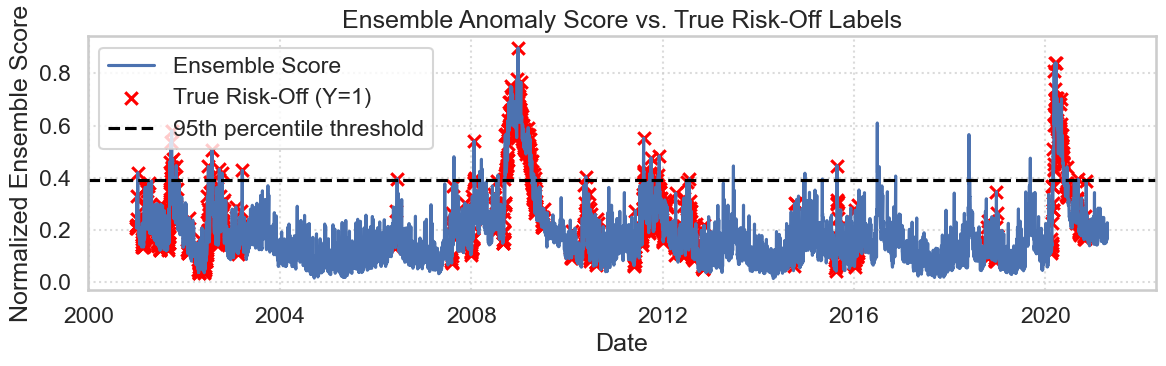

In [12]:
# 16) Ensemble anomaly detection via score averaging (self‐contained, including PC extraction)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report

# — Assumes you have already run your PCA block and have:
#    X_scaled   : numpy array of shape (n_samples, n_features_clean)
#    pca        : fitted PCA instance (with n_components ≥ 260)
#    X_clean    : DataFrame used to generate X_scaled (index aligned with df_features)
#    df_features: DataFrame containing your features + columns "Y" and "is_imputed"

# a) Build PC score DataFrame (using all 260 components)
pc_scores = pca.transform(X_scaled)  # shape (n_samples, n_components)
pc_df = pd.DataFrame(
    pc_scores,
    index=X_clean.index,
    columns=[f"PC{i}" for i in range(1, pc_scores.shape[1] + 1)]
)

# b) Define the “normal” training set (where Y == 0)
normal_idx = df_features["Y"] == 0
X_train    = pc_df.loc[normal_idx].values
X_all      = pc_df.values

# c) Set up base detectors (5% assumed contamination)
detectors = {
    "IF"   : IsolationForest(n_estimators=200, max_samples="auto",
                             contamination=0.05, random_state=0),
    "OCSVM": OneClassSVM(kernel="rbf", nu=0.05, gamma="scale"),
    "LOF"  : LocalOutlierFactor(n_neighbors=20, novelty=True,
                                 contamination=0.05),
    "EE"   : EllipticEnvelope(contamination=0.05, random_state=0)
}

# d) Fit each detector on normal data and gather normalized scores
scores = pd.DataFrame(index=pc_df.index)
for name, model in detectors.items():
    model.fit(X_train)                 # train on normal-only
    raw = -model.decision_function(X_all)  # anomaly score: higher = more anomalous
    # Min–max scale to [0,1]
    raw_min, raw_max = raw.min(), raw.max()
    scores[name] = (raw - raw_min) / (raw_max - raw_min)

# e) Build the ensemble (average) score and flag anomalies
scores["ensemble_score"] = scores.mean(axis=1)
df_features["ensemble_score"] = scores["ensemble_score"]

threshold = scores["ensemble_score"].quantile(0.95)
df_features["ensemble_flag"] = (df_features["ensemble_score"] >= threshold).astype(int)

# f) Evaluate against true labels
print("Classification report for ensemble (5% cutoff):")
print(classification_report(df_features["Y"], df_features["ensemble_flag"]))

# g) Plot ensemble scores vs. true risk-off weeks
plt.figure(figsize=(12, 4))
plt.plot(df_features.index, df_features["ensemble_score"], label="Ensemble Score")
plt.scatter(
    df_features.index[df_features["Y"] == 1],
    df_features["ensemble_score"][df_features["Y"] == 1],
    color="red", marker="x", label="True Risk-Off (Y=1)"
)
plt.axhline(threshold, color="black", linestyle="--", label="95th percentile threshold")
plt.legend()
plt.title("Ensemble Anomaly Score vs. True Risk-Off Labels")
plt.ylabel("Normalized Ensemble Score")
plt.xlabel("Date")
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

Meta‐model coefficients: {'IF': np.float64(-3.336606087366569), 'OCSVM': np.float64(-0.9207560774774743), 'LOF': np.float64(27.72164082930717), 'EE': np.float64(12.578044100859284)}

Classification report (stacked, thresh=0.5):
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3610
           1       0.59      0.54      0.57       805

    accuracy                           0.85      4415
   macro avg       0.75      0.73      0.74      4415
weighted avg       0.84      0.85      0.85      4415



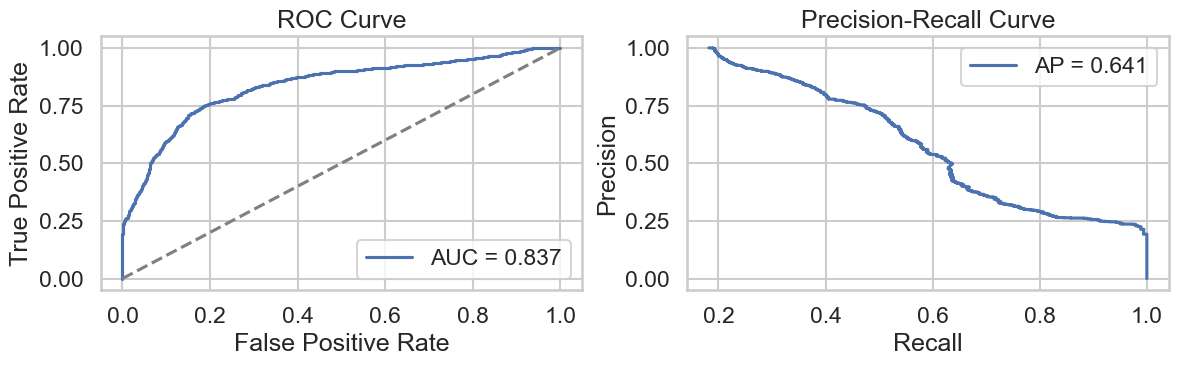

In [14]:
# 17) Stacked logistic‐regression meta‐model (manual time‐series CV)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    classification_report
)

# a) Meta‐features = the four base‐detector scores
meta_X = scores[["IF", "OCSVM", "LOF", "EE"]]
y      = df_features["Y"]

# b) Prepare container for out‐of‐fold probabilities
tscv = TimeSeriesSplit(n_splits=5)
meta_pred_proba = np.full(len(y), np.nan)

# c) Manual OOF loop: inner‐CV for hyperparameter tuning on each train fold
for train_idx, test_idx in tscv.split(meta_X):
    inner_clf = LogisticRegressionCV(
        Cs=10, cv=3, scoring="roc_auc",
        penalty="l2", max_iter=1000, solver="lbfgs",
        random_state=0
    )
    # Fit on the training split
    inner_clf.fit(meta_X.iloc[train_idx], y.iloc[train_idx])
    # Predict probabilities on the test split
    meta_pred_proba[test_idx] = inner_clf.predict_proba(
        meta_X.iloc[test_idx]
    )[:, 1]

# d) Re‐fit on full data for final model and coefficient inspection
meta_clf = LogisticRegressionCV(
    Cs=10, cv=tscv, scoring="roc_auc",
    penalty="l2", max_iter=1000, solver="lbfgs",
    random_state=0
)
meta_clf.fit(meta_X, y)
print("Meta‐model coefficients:", dict(zip(meta_X.columns, meta_clf.coef_[0])))

# e) Classification report at 0.5 threshold (only where we have OOF preds)
mask = ~np.isnan(meta_pred_proba)
meta_flag = (meta_pred_proba[mask] >= 0.5).astype(int)
print("\nClassification report (stacked, thresh=0.5):")
print(classification_report(y[mask], meta_flag))

# f) Plot ROC & Precision‐Recall curves
fpr, tpr, _   = roc_curve(y[mask], meta_pred_proba[mask])
roc_auc       = auc(fpr, tpr)
pr_x, pr_y, _ = precision_recall_curve(y[mask], meta_pred_proba[mask])
pr_auc        = average_precision_score(y[mask], meta_pred_proba[mask])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(pr_x, pr_y, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Dynamic ensemble classification report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4186
           1       0.92      0.23      0.37      1050

    accuracy                           0.84      5236
   macro avg       0.88      0.61      0.64      5236
weighted avg       0.85      0.84      0.80      5236



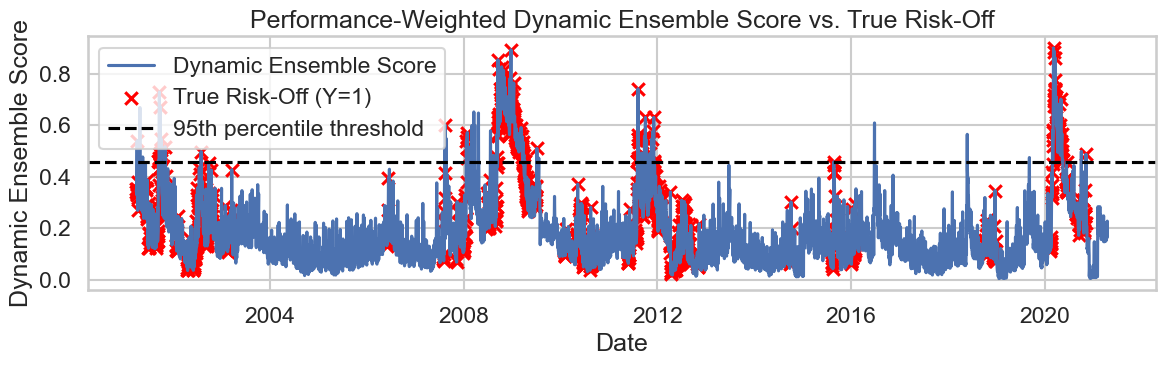

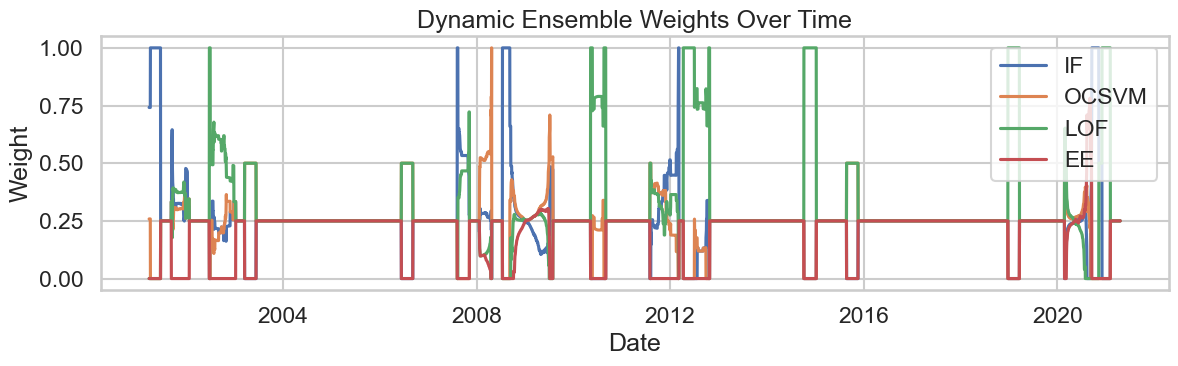

In [16]:
# 17) Performance-Weighted Dynamic Ensemble (with weight plotting)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score, classification_report

# — prereqs: you must have run PCA, static-ensemble cells so that:
#    • pc_df      : DataFrame of PC scores, indexed by date
#    • df_features: DataFrame with your features + column "Y"
#    • scores     : DataFrame of normalized anomaly scores for IF, OCSVM, LOF, EE

# 1) Base detectors
detectors = {
    "IF"   : IsolationForest(n_estimators=200, max_samples="auto",
                             contamination=0.05, random_state=0),
    "OCSVM": OneClassSVM(kernel="rbf", nu=0.05, gamma="scale"),
    "LOF"  : LocalOutlierFactor(n_neighbors=20, novelty=True,
                                 contamination=0.05),
    "EE"   : EllipticEnvelope(contamination=0.05, random_state=0)
}

# 2) (Re)compute normalized scores if needed
normal_idx = df_features["Y"] == 0
X_train = pc_df.loc[normal_idx].values
X_all   = pc_df.values
scores = pd.DataFrame(index=pc_df.index)
for name, model in detectors.items():
    model.fit(X_train)
    raw = -model.decision_function(X_all)  # higher = more anomalous
    scores[name] = (raw - raw.min()) / (raw.max() - raw.min())

# 3) Static flags at each model’s 95th percentile
static_thresh = {m: scores[m].quantile(0.95) for m in detectors}
flags = pd.DataFrame({
    m: (scores[m] >= static_thresh[m]).astype(int)
    for m in detectors
}, index=scores.index)

# 4) Sliding-window performance → weights → dynamic score
window_size = 63  # business days
dynamic_score   = pd.Series(index=scores.index, dtype=float)
dynamic_weights = pd.DataFrame(index=scores.index, columns=detectors.keys(), dtype=float)

for i, date in enumerate(scores.index):
    if i < window_size:
        dynamic_score.iat[i] = np.nan
        dynamic_weights.iloc[i] = np.nan
    else:
        window = scores.index[i-window_size:i]
        y_true = df_features.loc[window, "Y"]
        # compute F1 for each detector over last window
        perf = {m: f1_score(y_true, flags.loc[window, m], zero_division=0)
                for m in detectors}
        total = sum(perf.values())
        if total == 0:
            weights = {m: 1/len(detectors) for m in detectors}
        else:
            weights = {m: perf[m]/total for m in detectors}
        # store weights
        dynamic_weights.loc[date] = pd.Series(weights)
        # compute weighted sum of today’s normalized scores
        dynamic_score.iat[i] = sum(weights[m] * scores.at[date, m] for m in detectors)

# 5) Attach, threshold & evaluate
df_features["dynamic_score"] = dynamic_score
dyn_thresh = dynamic_score.quantile(0.95)
df_features["dynamic_flag"] = (dynamic_score >= dyn_thresh).astype(int)

mask = dynamic_score.notna()
print("Dynamic ensemble classification report:")
print(classification_report(df_features.loc[mask, "Y"],
                            df_features.loc[mask, "dynamic_flag"]))

# 6) Plot dynamic ensemble score
plt.figure(figsize=(12, 4))
plt.plot(df_features.index, df_features["dynamic_score"], label="Dynamic Ensemble Score")
plt.scatter(
    df_features.index[df_features["Y"] == 1],
    df_features["dynamic_score"][df_features["Y"] == 1],
    color="red", marker="x", label="True Risk-Off (Y=1)"
)
plt.axhline(dyn_thresh, color="black", linestyle="--", label="95th percentile threshold")
plt.legend()
plt.title("Performance-Weighted Dynamic Ensemble Score vs. True Risk-Off")
plt.ylabel("Dynamic Ensemble Score")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7) Plot dynamic weights over time
plt.figure(figsize=(12, 4))
for m in detectors:
    plt.plot(dynamic_weights.index, dynamic_weights[m], label=m)
plt.legend()
plt.title("Dynamic Ensemble Weights Over Time")
plt.ylabel("Weight")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

Rolling Meta-Learner classification report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      4186
           1       0.78      0.19      0.31      1050

    accuracy                           0.83      5236
   macro avg       0.80      0.59      0.61      5236
weighted avg       0.82      0.83      0.78      5236



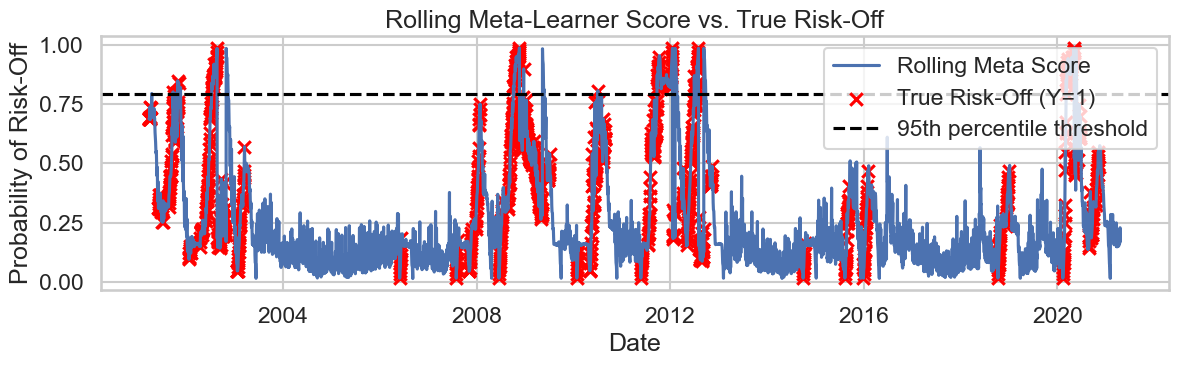

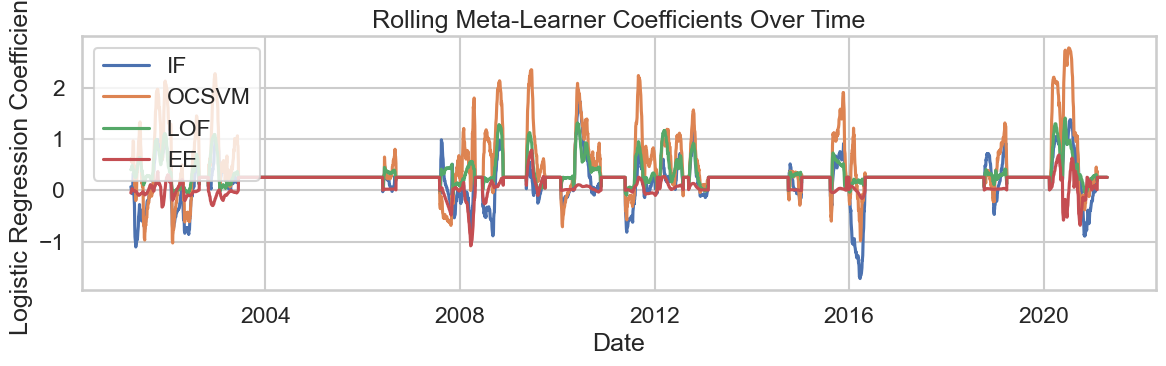

In [19]:
# 18) Rolling-Window Stacked Meta-Learner Dynamic Ensemble (with fallback for single-class windows)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# — prereqs: you must have run PCA & static-ensemble so that:
#    • pc_df      : DataFrame of PC scores, indexed by date
#    • df_features: DataFrame with your features + column "Y"

# 1) Base detectors
detectors = {
    "IF"   : IsolationForest(n_estimators=200, max_samples="auto",
                             contamination=0.05, random_state=0),
    "OCSVM": OneClassSVM(kernel="rbf", nu=0.05, gamma="scale"),
    "LOF"  : LocalOutlierFactor(n_neighbors=20, novelty=True,
                                 contamination=0.05),
    "EE"   : EllipticEnvelope(contamination=0.05, random_state=0)
}

# 2) Compute normalized anomaly scores (if not already done)
normal_idx = df_features["Y"] == 0
X_train    = pc_df.loc[normal_idx].values
X_all      = pc_df.values

scores = pd.DataFrame(index=pc_df.index)
for name, model in detectors.items():
    model.fit(X_train)
    raw = -model.decision_function(X_all)  # higher = more anomalous
    scores[name] = (raw - raw.min()) / (raw.max() - raw.min())

# 3) Rolling-window meta-learning
window_size     = 63  # business days
rolling_score   = pd.Series(index=scores.index, dtype=float)
rolling_weights = pd.DataFrame(index=scores.index,
                               columns=detectors.keys(),
                               dtype=float)

for i, date in enumerate(scores.index):
    if i < window_size:
        rolling_score.iat[i] = np.nan
        rolling_weights.iloc[i] = np.nan
    else:
        past_idx = scores.index[i-window_size:i]
        X_win = scores.loc[past_idx]
        y_win = df_features.loc[past_idx, "Y"]
        # If only one class in window, fallback to equal weights & average score
        if y_win.nunique() < 2:
            w = {m: 1/len(detectors) for m in detectors}
            rolling_weights.loc[date] = pd.Series(w)
            rolling_score.loc[date] = scores.loc[date].mean()
        else:
            # Train logistic meta‐model
            clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=0)
            clf.fit(X_win, y_win)
            # Coefficients as weights
            w = dict(zip(detectors.keys(), clf.coef_[0]))
            rolling_weights.loc[date] = pd.Series(w)
            # Predicted probability for today
            rolling_score.loc[date] = clf.predict_proba(scores.loc[[date]])[0, 1]

# 4) Attach to df_features, threshold & evaluate
df_features["rolling_meta_score"] = rolling_score
roll_thresh = rolling_score.quantile(0.95)
df_features["rolling_meta_flag"] = (rolling_score >= roll_thresh).astype(int)

mask = rolling_score.notna()
print("Rolling Meta-Learner classification report:")
print(classification_report(df_features.loc[mask, "Y"],
                            df_features.loc[mask, "rolling_meta_flag"]))

# 5) Plot rolling-meta anomaly scores
plt.figure(figsize=(12, 4))
plt.plot(df_features.index, df_features["rolling_meta_score"], label="Rolling Meta Score")
plt.scatter(
    df_features.index[df_features["Y"] == 1],
    df_features["rolling_meta_score"][df_features["Y"] == 1],
    color="red", marker="x", label="True Risk-Off (Y=1)"
)
plt.axhline(roll_thresh, color="black", linestyle="--", label="95th percentile threshold")
plt.legend()
plt.title("Rolling Meta-Learner Score vs. True Risk-Off")
plt.ylabel("Probability of Risk-Off")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) Plot rolling-meta weights over time
plt.figure(figsize=(12, 4))
for m in detectors:
    plt.plot(rolling_weights.index, rolling_weights[m], label=m)
plt.legend()
plt.title("Rolling Meta-Learner Coefficients Over Time")
plt.ylabel("Logistic Regression Coefficient")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()